Using device: cuda
Ticker: 000660, Action: sell, Proportion: 0.75, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 0 Step 0:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.75, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 1 Step 1:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.25, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 2 Step 2:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.5, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 3 Step 3:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.25, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 4 Step 4:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.75, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 5 Step 5:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: buy, Proportion: 0.5, Buy/Sell Amount: 5

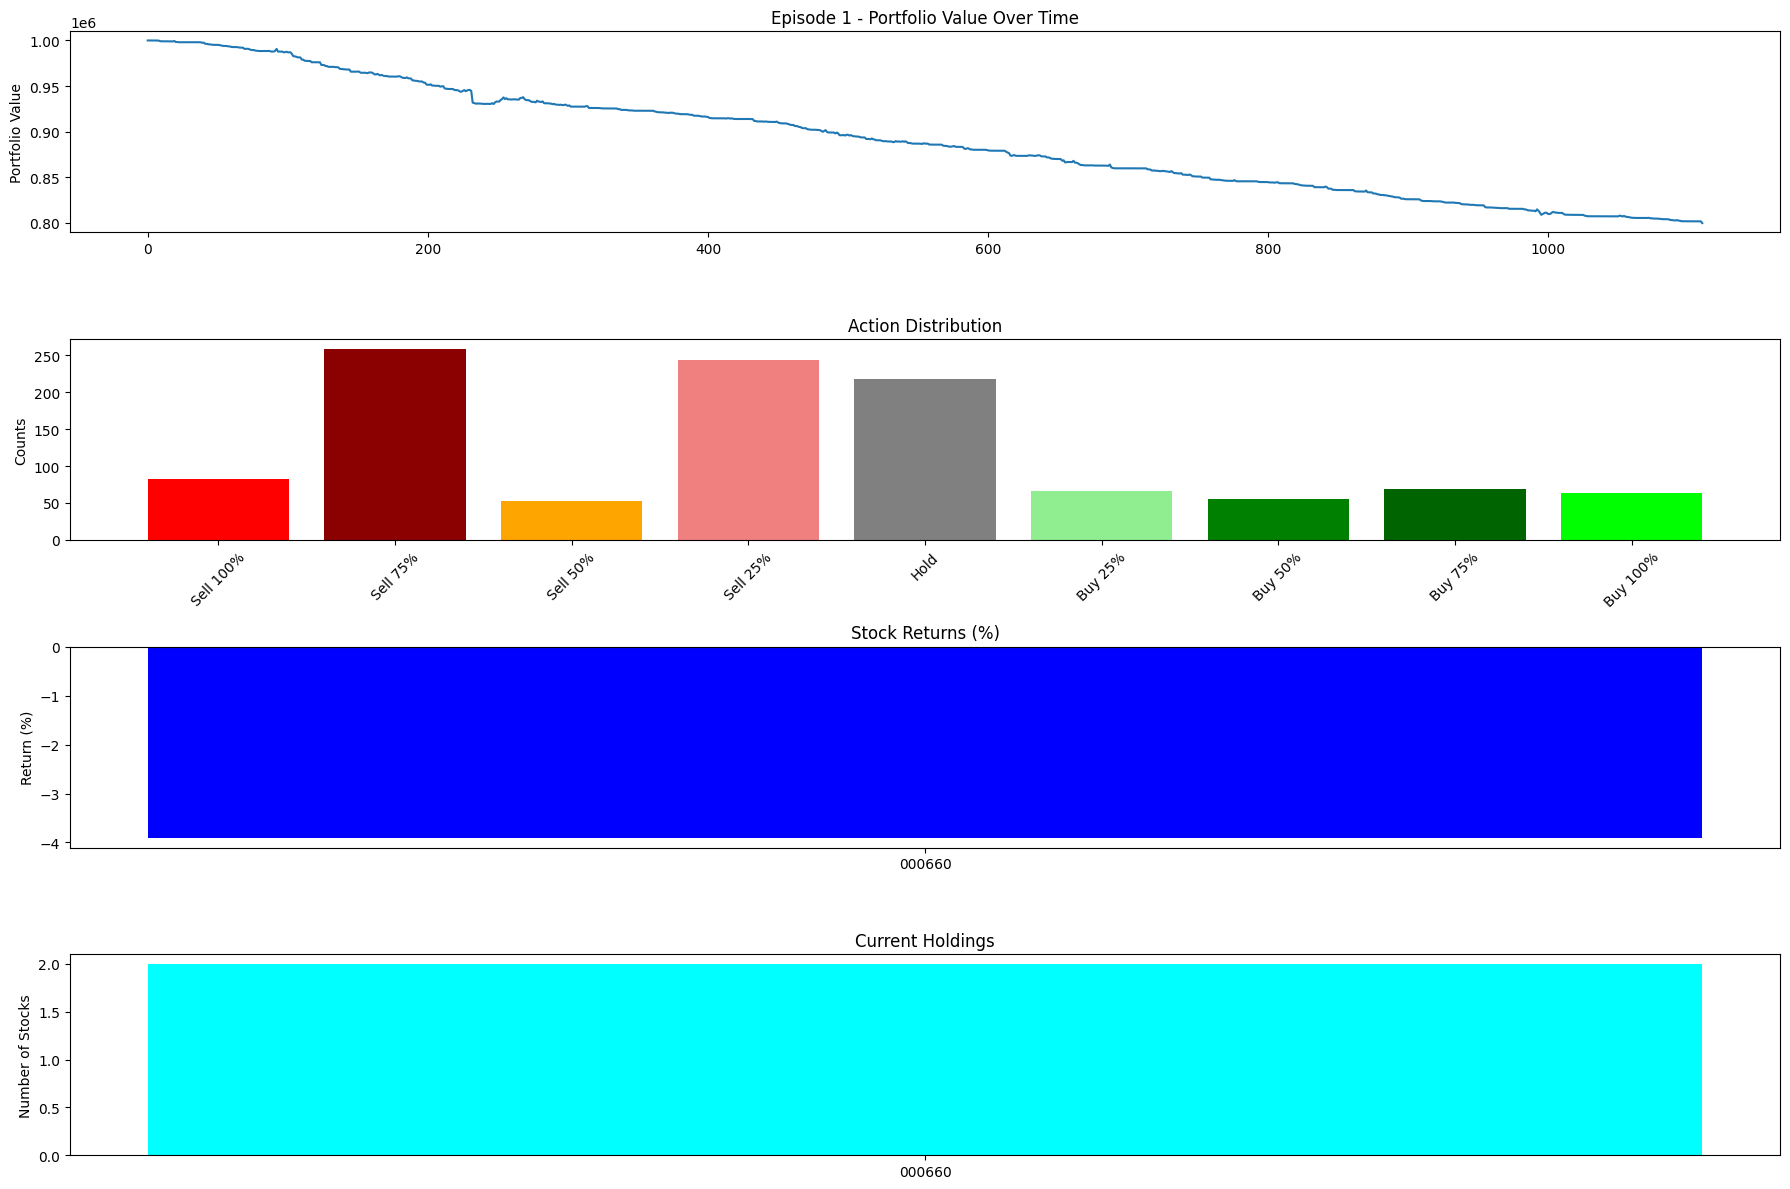

Episode 1 completed. Total Reward: -189991.53, Final Portfolio Value: 799725.94
Action counts:
  Sell 100%: 83
  Sell 75%: 259
  Sell 50%: 52
  Sell 25%: 244
  Hold: 218
  Buy 25%: 66
  Buy 50%: 56
  Buy 75%: 69
  Buy 100%: 63
--------------------------------------------------
Ticker: 000660, Action: sell, Proportion: 0.25, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 0 Step 0:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.75, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 1 Step 1:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.25, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 2 Step 2:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: sell, Proportion: 0.25, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 3 Step 3:
Cannot Sell 000660 (No holdings)

Ticker: 000660, Action: hold, Proportion: 0.0, Buy/Sell Amount: 0, Balance: 1000000.00, Holdings: 0
Episode 4 

KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import warnings

seq_length = 30
rsi_length = seq_length -1 
feature_count = 6
cols = ['Close', 'MA10', 'MA20', 'RSI','sell_vol', 'buy_vol' ]

# UserWarning 무시 (필요 시 제거 가능)
warnings.filterwarnings("ignore", category=UserWarning)

# 디바이스 설정 (GPU 사용 여부 확인)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_length):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_length, embed_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000) / embed_dim))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term) # 짝수
        self.encoding[:, 1::2] = torch.cos(position * div_term) # 홀수
        self.encoding = self.encoding.unsqueeze(0)
    
    def forward(self, x):
        # 입력 텐서 길이에 따라 포지셔널 인코딩 추가
        # seq_len = x.size(1)
        return x + self.encoding

# transformer 모듈 정의 (트랜스포머 기반 시계열 처리 모델)
class Transformer(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(Transformer, self).__init__()
        self.seq_length = seq_length
        self.embed_dim = embed_dim
        self.input_linear = nn.Linear(input_dim, embed_dim)
        
        # TransformerEncoderLayer에 batch_first=True 설정
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=dropout,
            batch_first=True  # batch_first 설정
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        x: [batch_size, seq_length, input_dim]
        """
        x = self.input_linear(x)  # [batch_size, seq_length, embed_dim]
        x = self.transformer_encoder(x)  # [batch_size, seq_length, embed_dim]
        x = self.output_linear(x)  # [batch_size, seq_length, embed_dim]
        x = self.activation(x)
        # 시퀀스의 마지막 타임스탬프 출력
        x = x[:, -1, :]           # [batch_size, embed_dim]
        return x



# 다중 종목 주식 트레이딩 환경 정의
class MultiStockTradingEnv(gym.Env):
    def __init__(self, dfs, stock_dim=1, initial_balance=1000000000, max_stock=100, seq_length=20):
        super(MultiStockTradingEnv, self).__init__()
        self.dfs = dfs  # 종목별 데이터프레임 딕셔너리
        self.stock_dim = stock_dim  # 종목 수
        self.initial_balance = initial_balance  # 초기 자본금
        self.max_stock = max_stock  # 각 종목당 최대 보유 주식 수
        self.transaction_fee = 0.00015  # 거래 수수료 0.25%
        self.national_tax = 0.0018
        self.slippage = 0.0  # 슬리피지 0.3%
        self.max_loss = 0.2  # 최대 허용 손실 (20%)
        self.seq_length = seq_length  # 시퀀스 길이

        # 상태 공간: 시퀀스 길이에 따른 각 종목의 [Close, MA10, MA20, RSI]와 보유 주식 수
        # plus balance
        # 각 종목: (4 * seq_length) + 1 (보유 주식 수)
        # 총: stock_dim * (4 * seq_length +1) + 1 (balance)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.stock_dim * (feature_count * self.seq_length + 1) + 1,), dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([9] * self.stock_dim)  # 각 종목별로 9개의 액션

        # 초기화
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.portfolio_value = self.initial_balance
        self.current_step = 0
        self.stock_owned = {ticker: {'quantity': 0, 'avg_price': 0} for ticker in self.dfs.keys()}
        self.stock_price = {}
        self.total_asset = []

        # 히스토리 초기화
        self.balance_history = [self.balance]
        self.portfolio_value_history = [self.portfolio_value]
        self.action_history = []
        self.price_history = {ticker: [] for ticker in self.dfs.keys()}
        self.trade_history = []  # 매수/매도 내역 저장

        # 각 종목의 최대 스텝 수 계산
        self.max_steps = min(len(df) for df in self.dfs.values()) - self.seq_length - 1
        if self.max_steps <= 0:
            raise ValueError("데이터프레임의 길이가 시퀀스 길이보다 짧습니다.")

        # 각 종목의 현재 인덱스 초기화
        self.data_indices = {ticker: self.seq_length for ticker in self.dfs.keys()}  # 시퀀스 길이만큼 초기 인덱스

        return self._next_observation()

    def _next_observation(self):
        obs = []
        for ticker, df in self.dfs.items():
            idx = self.data_indices[ticker]
            if idx < self.seq_length:
                # 충분한 시퀀스가 없으면 제로 패딩
                seq = df.loc[:idx, cols].values
                pad_length = self.seq_length - seq.shape[0]
                if pad_length > 0:
                    pad = np.zeros((pad_length, feature_count))
                    seq = np.vstack((pad, seq))
            else:
                # 시퀀스 슬라이싱
                seq = df.loc[idx - self.seq_length:idx - 1, cols].values
            obs.extend(seq.flatten())  # [seq_length * 4]
            obs.append(self.stock_owned[ticker]['quantity'])  # [1]

            # 현재 가격 저장 (iloc 사용)
            self.stock_price[ticker] = df.iloc[idx]['Close_unscaled']

        # 잔고 추가
        obs.append(self.balance)  # [1]

        return np.array(obs, dtype=np.float32)

    def step(self, actions):
        done = False
        total_reward = 0
        invalid_action_penalty = -10  # 불가능한 행동에 대한 페널티
        self.action_history.append(actions)
        trade_info = []  # 현재 스텝의 거래 내역

        prev_portfolio_value = self.portfolio_value  # 이전 포트폴리오 가치 저장

        # 액션 맵핑 정의
        action_mapping = {
            0: ('sell', 1.0),
            1: ('sell', 0.75),
            2: ('sell', 0.5),
            3: ('sell', 0.25),
            4: ('hold', 0.0),
            5: ('buy', 0.25),
            6: ('buy', 0.5),
            7: ('buy', 0.75),
            8: ('buy', 1.0)
        }

        # 종목별로 행동 수행
        for i, (ticker, df) in enumerate(self.dfs.items()):
            action = actions[i]
            idx = self.data_indices[ticker]

            # 인덱스가 데이터프레임의 범위를 벗어나면 에피소드를 종료
            if idx >= len(df):
                done = True
                trade_info.append(f"Ticker {ticker} reached end of data. Ending episode.")
                break

            actual_price = df.iloc[idx]['Close_unscaled']

            # 액션 맵핑을 통해 행동 타입과 비율 얻기
            action_type, proportion = action_mapping.get(action, ('hold', 0.0))

            # 슬리피지 적용
            if action_type == 'buy':
                adjusted_price = actual_price * (1 + self.slippage)
            elif action_type == 'sell':
                adjusted_price = actual_price * (1 - self.slippage)
            else:
                adjusted_price = actual_price

            # 거래 수수료 계산
            buy_fee = adjusted_price * self.transaction_fee
            sell_fee = adjusted_price * (self.transaction_fee + self.national_tax)

            # buy_amount과 sell_amount 초기화
            buy_amount = 0
            sell_amount = 0

            # 행동에 따른 포트폴리오 업데이트 및 보상 계산
            reward = 0  # 각 종목별 보상 초기화
            if action_type == 'sell':
                if self.stock_owned[ticker]['quantity'] > 0:
                    sell_amount = int(self.stock_owned[ticker]['quantity'] * proportion)
                    sell_amount = max(1, sell_amount)  # 최소 1주 매도
                    sell_amount = min(sell_amount, self.stock_owned[ticker]['quantity'])  # 보유 주식 수 초과 방지
                    proceeds = adjusted_price * sell_amount - sell_fee * sell_amount
                    self.balance += proceeds
                    # 이익 또는 손실 계산
                    profit = (adjusted_price - self.stock_owned[ticker]['avg_price']) * sell_amount - sell_fee * sell_amount
                    reward = profit  # 매도 시 보상은 이익 또는 손실
                    self.stock_owned[ticker]['quantity'] -= sell_amount
                    if self.stock_owned[ticker]['quantity'] == 0:
                        self.stock_owned[ticker]['avg_price'] = 0
                    trade_info.append(f"Sell {sell_amount} of {ticker} at {adjusted_price:.2f}")
                else:
                    # 보유한 주식이 없으면 페널티 부여
                    reward = invalid_action_penalty
                    trade_info.append(f"Cannot Sell {ticker} (No holdings)")
            elif action_type == 'buy':
                max_can_buy = min(
                    self.max_stock - self.stock_owned[ticker]['quantity'],
                    int(self.balance // (adjusted_price + buy_fee))
                )
                buy_amount = int(max_can_buy * proportion)
                buy_amount = max(1, buy_amount)  # 최소 1주 매수
                buy_amount = min(buy_amount, self.max_stock - self.stock_owned[ticker]['quantity'], 
                                 int(self.balance // (adjusted_price + buy_fee)))
                if buy_amount > 0:
                    cost = adjusted_price * buy_amount + buy_fee * buy_amount
                    self.balance -= cost
                    # 평균 매수가격 업데이트
                    total_quantity = self.stock_owned[ticker]['quantity'] + buy_amount
                    if total_quantity > 0:
                        self.stock_owned[ticker]['avg_price'] = (
                            (self.stock_owned[ticker]['avg_price'] * self.stock_owned[ticker]['quantity'] + adjusted_price * buy_amount)
                            / total_quantity
                        )
                    self.stock_owned[ticker]['quantity'] = total_quantity
                    reward = 0  # 매수 시 보상 없음
                    trade_info.append(f"Buy {buy_amount} of {ticker} at {adjusted_price:.2f}")
                else:
                    reward = invalid_action_penalty  # 매수 불가 시 페널티
                    trade_info.append(f"Cannot Buy {ticker} (Insufficient balance or max stock)")
            else:
                trade_info.append(f"Hold {ticker}")

            # 보상 누적
            total_reward += reward

            # 가격 히스토리 업데이트
            self.price_history[ticker].append(actual_price)

            # 다음 인덱스로 이동
            self.data_indices[ticker] += 1

            # 디버깅을 위한 로그 출력
            print(f"Ticker: {ticker}, Action: {action_type}, Proportion: {proportion}, "
                  f"Buy/Sell Amount: {buy_amount if action_type == 'buy' else sell_amount if action_type == 'sell' else 0}, "
                  f"Balance: {self.balance:.2f}, Holdings: {self.stock_owned[ticker]['quantity']}")
            
            
            # if i % 10 == 0:
            #     print(f"Ticker: {ticker}, Action: {action_type}, Proportion: {proportion}, "
            #           f"Buy/Sell Amount: {buy_amount if action_type == 'buy' else sell_amount if action_type == 'sell' else 0}, "
            #           f"Balance: {self.balance:.2f}, Holdings: {self.stock_owned[ticker]['quantity']}"
            #           f"Total reward: {total_reward:.4f}")
            
            # 잔고와 보유 주식 수량이 음수가 되지 않도록 방지
            if self.balance < 0:
                print(f"Warning: Balance for {ticker} is negative! Setting to 0.")
                self.balance = 0
            if self.stock_owned[ticker]['quantity'] < 0:
                print(f"Warning: Holdings for {ticker} are negative! Setting to 0.")
                self.stock_owned[ticker]['quantity'] = 0
                self.stock_owned[ticker]['avg_price'] = 0

        # 현재 스텝의 거래 내역 저장 및 출력
        if trade_info:
            print(f"Episode {self.current_step} Step {self.current_step}:")
            for info in trade_info:
                print(info)
            print()

        self.trade_history.append(trade_info)

        # 현재 포트폴리오 가치 계산
        self.portfolio_value = self.balance + sum(
            self.stock_owned[ticker]['quantity'] * self.stock_price[ticker] for ticker in self.dfs.keys()
        )
        self.total_asset.append(self.portfolio_value)

        # 보상은 포트폴리오 가치의 비율적 변화량을 사용
        if prev_portfolio_value > 0:
            portfolio_return = (self.portfolio_value - prev_portfolio_value) / prev_portfolio_value  # 비율적 변화
        else:
            portfolio_return = 0  # 이전 포트폴리오 가치가 0일 경우
        scaled_reward = portfolio_return * 100  # 예: 0.01 -> 1%
        total_reward += scaled_reward  # 전체 보상에 추가

        # 포트폴리오 가치가 음수가 되지 않도록 보장
        if self.portfolio_value < 0:
            print(f"Error: Portfolio value is negative! Setting to 0.")
            self.portfolio_value = 0
            self.balance = 0  # 잔고도 0으로 설정
            done = True  # 에피소드를 종료

        # 최대 허용 손실 초과 시 종료
        if self.portfolio_value < self.initial_balance * (1 - self.max_loss):
            done = True

        # 최대 스텝 수 초과 시 종료
        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True

        # 히스토리 업데이트
        self.balance_history.append(self.balance)
        self.portfolio_value_history.append(self.portfolio_value)

        obs = self._next_observation()
        return obs, total_reward, done, {}


# ================================================================================================================================================



# 데이터 로드 및 기술적 지표 계산
tickers = ['000660']
dfs = {}
for ticker in tickers:
    # df = yf.download(ticker, start='2020-01-01', end='2020-12-31', progress=False)
    df = pd.read_csv(f'{ticker}.csv',encoding='cp949')
    df = df.rename(columns={'종가':'Close', '매도량':'sell_vol' , '매수량':'buy_vol'})
    # 원래의 Close 가격 보존
    df.loc[:, 'Close_unscaled'] = df['Close']  # 실제 가격 저장

    # 기술적 지표 계산
    df.loc[:, 'MA10'] = df['Close'].rolling(window=10).mean()
    df.loc[:, 'MA20'] = df['Close'].rolling(window=20).mean()

    # RSI 계산
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=rsi_length, adjust=False).mean()
    ema_down = down.ewm(com=rsi_length, adjust=False).mean()
    rs = ema_up / ema_down
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    df = df.dropna().copy()  # 복사하여 경고 방지

    # 입력 데이터 정규화
    scaler = StandardScaler()
    feature_cols = cols
    df.loc[:, feature_cols] = scaler.fit_transform(df[feature_cols])

    dfs[ticker] = df.reset_index(drop=True)

# 환경 생성 (초기 자본금 증가 및 시퀀스 길이 설정)
env = MultiStockTradingEnv(dfs, initial_balance=1000000, seq_length=seq_length)

# PPO를 위한 액터-크리틱 신경망 정의
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim_list, seq_length=20):
        super(ActorCritic, self).__init__()
        self.seq_length = seq_length
        # self.input_dim = input_dim
        self.transformer = Transformer(input_dim=feature_count, seq_length=seq_length).to(device)  # input_dim=4 (Close, MA10, MA20, RSI)
        self.policy_head = nn.ModuleList([nn.Linear(self.transformer.embed_dim, action_dim) for action_dim in action_dim_list])
        self.value_head = nn.Linear(self.transformer.embed_dim * len(action_dim_list), 1)  # embed_dim * stock_dim
        self.apply(self._weights_init)  # 가중치 초기화

    def _weights_init(self, m):
        if isinstance(m, nn.Linear):
            # 정책 헤드의 바이어스를 0으로 초기화하여 행동 확률 균등화
            nn.init.zeros_(m.bias)
            nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        """
        x: [batch_size, stock_dim * (4 * seq_length + 1) + 1]
        """
        stock_embeds = []
        for i, ticker in enumerate(tickers):
            # 각 종목의 시퀀스 데이터: [batch_size, 4 * seq_length]
            start = i * (feature_count * self.seq_length + 1)
            end = start + feature_count * self.seq_length
            seq = x[:, start:end]
            # Reshape to [batch_size, seq_length, 4]
            seq = seq.view(-1, self.seq_length, feature_count)
            embed = self.transformer(seq)  # [batch_size, embed_dim]
            stock_embeds.append(embed)
        # 정책 헤드는 각 embed를 처리하여 policy logits을 생성
        policy_logits = [head(embed) for embed, head in zip(stock_embeds, self.policy_head)]  # [batch_size, 9] * stock_dim
        # 가치 함수는 모든 embed를 합쳐 처리
        combined_embeds = torch.cat(stock_embeds, dim=1)  # [batch_size, embed_dim * stock_dim]
        value = self.value_head(combined_embeds)  # [batch_size, 1]
        return policy_logits, value

    def act(self, state):
        state = state.to(device)
        policy_logits, _ = self.forward(state)
        actions = []
        action_logprobs = []
        for logits in policy_logits:
            
            dist = Categorical(logits=logits)
            action = dist.sample()
            actions.append(action.item())
            action_logprob = dist.log_prob(action)
            action_logprobs.append(action_logprob)
        return np.array(actions), torch.stack(action_logprobs)

    def evaluate(self, state, actions):
        policy_logits, value = self.forward(state)
        action_logprobs = []
        dist_entropies = []
        for i, logits in enumerate(policy_logits):
            dist = Categorical(logits=logits)
            action_logprob = dist.log_prob(actions[:, i])
            dist_entropy = dist.entropy()
            action_logprobs.append(action_logprob)
            dist_entropies.append(dist_entropy)
        return torch.stack(action_logprobs, dim=1), value.squeeze(-1), torch.stack(dist_entropies, dim=1)

# 하이퍼파라미터 설정
learning_rate = 1e-4  # 학습률
gamma = 0.8
epsilon = 0.2
epochs = 100  # 에폭 수

# 정책 및 옵티마이저 초기화
input_dim = env.observation_space.shape[0]
action_dim_list = [9] * env.stock_dim  # 각 종목별 9개의 액션
policy = ActorCritic(input_dim, action_dim_list, seq_length=env.seq_length).to(device)  # 모델을 GPU로 이동
optimizer = optim.AdamW(policy.parameters(), lr=learning_rate)

# 메모리 클래스 정의
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

memory = Memory()

# PPO 업데이트 함수 정의
def ppo_update():
    if len(memory.states) == 0:
        return  # 메모리가 비어있으면 업데이트하지 않음

    # 리스트를 텐서로 변환하고 GPU로 이동
    states = torch.tensor(memory.states, dtype=torch.float32).to(device)
    actions = torch.tensor(memory.actions, dtype=torch.int64).to(device)
    old_logprobs = torch.tensor(memory.logprobs, dtype=torch.float32).to(device)
    rewards = memory.rewards
    is_terminals = memory.is_terminals

    # 리턴 계산 (할인 보상)
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
        if is_terminal:
            discounted_reward = 0
        discounted_reward = reward + (gamma * discounted_reward)
        returns.insert(0, discounted_reward)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # 어드밴티지 계산
    with torch.no_grad():
        _, state_values = policy.forward(states)
        advantages = returns - state_values.squeeze(-1)
        # 어드밴티지 정규화
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # 정책 업데이트
    for epoch in range(epochs):
        action_logprobs, state_values, dist_entropies = policy.evaluate(states, actions)
        # 정책 헤드별 로그 확률 합계
        total_logprobs = action_logprobs.sum(dim=1)
        # 정책 헤드별 엔트로피 합계
        total_entropies = dist_entropies.sum(dim=1)
        ratios = torch.exp(total_logprobs - old_logprobs)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages
        # 가치 함수 손실 추가
        value_loss = F.mse_loss(state_values.squeeze(-1), returns)
        entropy_coef = 0.01  # 엔트로피 계수 감소
        loss = -torch.min(surr1, surr2) + 0.5 * value_loss - entropy_coef * total_entropies

        optimizer.zero_grad()
        loss_mean = loss.mean()
        loss_mean.backward()

        # 그레이디언트 클리핑
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
        optimizer.step()

        # 손실 값 출력
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss_mean.item():.4f}")

# 학습 루프
max_episodes = 100  # 에피소드 수

for episode in range(max_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)  # [1, state_dim]
        actions, action_logprobs = policy.act(state_tensor)
        actions = actions  # [stock_dim]
        next_state, reward, done, _ = env.step(actions)
        total_reward += reward
        # 메모리에 데이터 저장
        memory.states.append(state)
        memory.actions.append(actions)
        memory.logprobs.append(action_logprobs.sum().item())
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        state = next_state

    # 정책 업데이트 및 메모리 초기화
    ppo_update()
    memory.clear()

    # 행동 분포 시각화
    action_counts = np.zeros(9)
    for actions in env.action_history:
        action_counts += np.bincount(actions, minlength=9)
    plt.figure(figsize=(18, 12))

    # 포트폴리오 가치 변화 시각화
    plt.subplot(4, 1, 1)
    plt.plot(env.portfolio_value_history)
    plt.title(f'Episode {episode+1} - Portfolio Value Over Time')
    plt.ylabel('Portfolio Value')

    # 행동 분포 시각화
    plt.subplot(4, 1, 2)
    action_labels = ['Sell 100%', 'Sell 75%', 'Sell 50%', 'Sell 25%', 'Hold', 
                    'Buy 25%', 'Buy 50%', 'Buy 75%', 'Buy 100%']
    plt.bar(action_labels, action_counts, color=['red', 'darkred', 'orange', 'lightcoral', 'gray', 
                                                'lightgreen', 'green', 'darkgreen', 'lime'])
    plt.title('Action Distribution')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)

    # 종목별 수익률 시각화
    plt.subplot(4, 1, 3)
    initial_prices = {ticker: env.price_history[ticker][0] for ticker in tickers}
    final_prices = {ticker: env.price_history[ticker][-1] for ticker in tickers}
    returns = []
    for ticker in tickers:
        if initial_prices[ticker] == 0:
            ret = 0
        else:
            ret = (final_prices[ticker] - initial_prices[ticker]) / initial_prices[ticker] * 100
        returns.append(ret)
    plt.bar(tickers, returns, color=['blue', 'orange', 'purple'])
    plt.title('Stock Returns (%)')
    plt.ylabel('Return (%)')

    # 종목별 보유 주식 수 시각화
    plt.subplot(4, 1, 4)
    hold_counts = [env.stock_owned[ticker]['quantity'] for ticker in tickers]
    plt.bar(tickers, hold_counts, color=['cyan', 'magenta', 'yellow'])
    plt.title('Current Holdings')
    plt.ylabel('Number of Stocks')

    plt.tight_layout()
    plt.show()

    print(f"Episode {episode+1} completed. Total Reward: {total_reward:.2f}, Final Portfolio Value: {env.portfolio_value_history[-1]:.2f}")
    print(f"Action counts:")
    for i, label in enumerate(action_labels):
        print(f"  {label}: {int(action_counts[i])}")
    print('-' * 50)
